# OFAT SA

In [2]:
%matplotlib inline
from model import *
from agents import *
from globals import *
# from server import *
from schedule import *
from utility import *
from SALib.sample import saltelli
from mesa.batchrunner import BatchRunner, BatchRunnerMP
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import clear_output
import multiprocessing as mp

In [ ]:
fixed_params = {
    "N": 1000,
    "network_type": 2,
    "no_of_neighbors": 3,
    "beta_component": 0.15,
    "social_influence": 0.06,
    "swingers": 3,
    "malicious_N":0,
    "echo_limit": .95,
    "all_majority": False,
    "opinions":2,
    
}
 

variable_params = {
        "opinions":range(2, 6),
    #"N": range(100, 20, 50),
#     "no_of_neighbors": range(2, 4),
#     "beta_component": np.arange(0.0, 1.0, 0.2),
#     "similarity_treshold": np.arange(0.01, 0.11, 0.02),
#     "social_influence": np.arange(0.01, 0.11, 0.02),
#     "swingers": range(1, 5),
#     "echo_threshold": np.arange(0.05,0.21,0.01),
#     "opinions": range(2,6)
}

# print(variable_params['echo_threshold'])

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 30
max_steps = 100

# Set the outputs
model_reporters = {
#                 "preferences": compute_preferences,
#                 "opinions": compute_opinions,
#                 "preference_A": compute_preference_A,
#                 "preference_B": compute_preference_B,
                "radical_opinions": compute_radical_opinions,
                "community_no": community_no,
                "echo_chambers": echo_no,
                "majority_opinion": compute_majority_opinions,
                "silent_spiral": compute_silent_spiral,
                "compute_transitivity":compute_transitivity
}

data = {}

  
batch = BatchRunnerMP(Network, 
                    max_steps=max_steps,
                    iterations=replicates,
                    fixed_parameters=fixed_params,
                    variable_parameters=variable_params,
                    model_reporters=model_reporters, 
                    nr_processes=4,
                    display_progress=True)
    
batch.run_all()
data = batch.get_model_vars_dataframe()

#print data
print(data)


In [ ]:
data.to_pickle('./Data/OFAT_NWsize.pkl')

In [ ]:
# Example plots for varying beta component

replicates = 5
distinct_samples = 5

beta_component = np.arange(0.0, 1.0, 0.2)

# community number
count=0
list_mean_community_no = []
list_err_community_no = []
for i in range(distinct_samples):
    community_no = []
    for j in range(replicates):
        community_no.append(data.community_no[count + j])
    count = count + j + 1
    mean = np.mean(community_no)
    std = np.std(community_no)
    err = 1.96 * std / np.sqrt(replicates)
    list_mean_community_no.append(mean)
    list_err_community_no.append(err)

# radical opinions
count=0
list_mean_radical_opinions = []
list_err_radical_opinions = []
for i in range(distinct_samples):
    radical_opinions = []
    for j in range(replicates):
        radical_opinions.append(data.radical_opinions[count + j])
    count = count + j + 1
    mean = np.mean(radical_opinions)
    std = np.std(radical_opinions)
    err = 1.96 * std / np.sqrt(replicates)
    list_mean_radical_opinions.append(mean)
    list_err_radical_opinions.append(err)


ax1 = plt.subplot(211, xticklabels=[])
plt.errorbar(beta_component, list_mean_community_no, yerr=list_err_community_no, marker='s', linestyle='None')
plt.ylabel('community number')

ax2 = plt.subplot(212, sharex = ax1)
plt.errorbar(beta_component, list_mean_radical_opinions, yerr=list_err_radical_opinions, marker='s', linestyle='None')
plt.xlabel('beta component')
plt.ylabel('radical opinions')

plt.subplots_adjust(hspace=.0)
plt.show()

# Sobol SA

In [9]:
#### %matplotlib inline
from model import *
from agents import *
from globals import *
# from server import *
from schedule import *
from utility import *
from SALib.sample import saltelli
from mesa.batchrunner import BatchRunner, BatchRunnerMP
import pathos
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import clear_output
import time
import multiprocessing as mp
import analysis



In [54]:
# We define our variables and bounds

fixed_params = {
    "network_type": 2
}

problem = {
    'num_vars':6,
    'names': ['similarity_treshold', 'social_influence', 'swingers', 'no_of_neighbors', 'echo_limit',"opinions"],
    'bounds': [[0.01,0.1], [0.01, 0.1], [1, 5], [2,6], [0.80,0.95], [2,5]]
}

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 30
max_steps = 100
distinct_samples = 10

# We get all our samples here
param_values = saltelli.sample(problem, distinct_samples, calc_second_order= False)


In [11]:


# DIRK ZIJN DISTINCT SAMPLES
DIRK = param_values[len(param_values)//2:]

#TOBIAS ZIJN DISTINCT SAMPLES
# TOBIAS = param_values[:len(param_values)//2]


In [ ]:
# Set the outputs
model_reporters = {
#                 "preferences": compute_preferences,
#                 "opinions": compute_opinions,
#                 "preference_A": compute_preference_A,
#                 "preference_B": compute_preference_B,
                "radical_opinions": compute_radical_opinions,
                "Silent_Spiral": compute_silent_spiral,
                "majority_percentage": compute_majority_opinions,
                "community_no": community_no,
                "transitivity": compute_transitivity,
                "echo_chamber": compute_echo_chamber,
                "echo_size": echochamber_size,
                "echo_count": echochamber_count,          
}

param_values = DIRK
# param_values = TOBIAS

# BatchRunner
batch = BatchRunnerMP(Network, 
                    max_steps=max_steps,
                    fixed_parameters=fixed_params,
                    variable_parameters={name:[] for name in problem['names']},
                    model_reporters=model_reporters, nr_processes=8)
times = []
count = 0
for i in range(replicates):
    for vals in param_values:
        start = time.time()
        # Change parameters that should be integers
        vals = list(vals)
#         vals[2] = int(vals[2])

        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val
        variable_parameters['network_type']=2
        variable_parameters['malicious_N']=0
        variable_parameters['N']=1000
        variable_parameters['beta_component']=1
        variable_parameters['swingers']=int(variable_parameters['swingers'])
        variable_parameters['no_of_neighbors']=int(variable_parameters['no_of_neighbors'])
        variable_parameters['all_majority']=False
        variable_parameters['opinions']=int(variable_parameters['opinions'])

        batch.run_iteration(variable_parameters, tuple(vals), count)
        count += 1

        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')
        times.append(time.time() - start)
        meantime = np.mean(times)
        print('Average duration per iteration: %s seconds.'%str(meantime))
        nectime = ((len(param_values) * (replicates))-count)*meantime
        print('Expected time till finish: ', int(nectime/3600), 'hours and ', int((nectime%3600)/60), ' minutes.')
        
        
    
data = batch.get_model_vars_dataframe()
data.to_pickle('./Data/Dirk_Sobol_BA.pkl')


In [ ]:
print(data)

In [ ]:
# data.to_pickle()
# pickle.dump(data, './Data/Dirk_Sobol_BA_2.pkl')
# data = pd.read_pickle('data.pkl')

In [7]:
# def plot_index(s, params, i, title=''):
#     """
#     Creates a plot for Sobol sensitivity analysis that shows the contributions
#     of each parameter to the global sensitivity.

#     Args:
#         s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
#             the values for a set of parameters
#         params (list): the parameters taken from s
#         i (str): string that indicates what order the sensitivity is.
#         title (str): title for the plot
#     """

#     if i == '2':
#         p = len(params)
#         params = list(combinations(params, 2))
#         indices = s['S' + i].reshape((p ** 2))
#         indices = indices[~np.isnan(indices)]
#         errors = s['S' + i + '_conf'].reshape((p ** 2))
#         errors = errors[~np.isnan(errors)]
#     else:
#         indices = s['S' + i]
#         errors = s['S' + i + '_conf']
#         plt.figure()

#     l = len(indices)

#     plt.title(title)
#     plt.ylim([-0.2, len(indices) - 1 + 0.2])
#     plt.yticks(range(l), params)
#     plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
#     plt.axvline(0, c='k')
    
# for Si in ("opinions", "radical_opinions"):
#     # First order
#     plot_index(Si, problem['names'], '1', 'First order sensitivity')
#     plt.savefig('a')
#     plt.show()

#     # Second order
# #     plot_index(Si, problem['names'], '2', 'Second order sensitivity')
# #     plt.show()

#     # Total order
#     plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
#     plt.show()

NameError: name 'problem' is not defined

In [91]:
import _pickle as cPickle
import pandas as pd

print(np.__version__)
print(pd.__version__)

path_pickle = './Data/Dirk_Sobol_BA.pkl'

with open(path_pickle, 'rb') as fo:
    data = cPickle.load(fo, encoding='latin1')
                            
# D_data = data
# data = D
# path_pickle = './Data/Tobias_data.json'

# T_data = pd.read_json(path_pickle, lines=True)

# print(T_data)          
# # T_data = data
# frames = [D_data,T_data]

# data = D_data.append(T_data)
# print(data['echo_count'])

1.16.1
0.22.0


In [92]:
print(data)

      similarity_treshold  social_influence  swingers  no_of_neighbors  \
0                0.086025          0.097451  3.574219         5.207031   
1                0.092881          0.097451  3.574219         5.207031   
2                0.086025          0.057197  3.574219         5.207031   
3                0.086025          0.097451  4.503906         5.207031   
4                0.086025          0.097451  3.574219         2.777344   
5                0.086025          0.097451  3.574219         5.207031   
6                0.086025          0.097451  3.574219         5.207031   
7                0.092881          0.057197  4.503906         2.777344   
8                0.063525          0.029951  2.574219         2.207031   
9                0.025381          0.029951  2.574219         2.207031   
10               0.063525          0.079697  2.574219         2.207031   
11               0.063525          0.029951  3.503906         2.207031   
12               0.063525          0.0

[1200 rows x 16 columns]


In [93]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)
    
    plt.figure(dpi=100)
    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')


In [94]:
print(problem,data['echo_count'])
echo_count = sobol.analyze(problem, data['echo_count'].as_matrix(), print_to_console=True, calc_second_order=False)      
Silent_Spiral = sobol.analyze(problem, data['Silent_Spiral'].as_matrix(), print_to_console=True, calc_second_order=False)      
community_no = sobol.analyze(problem, data['community_no'].as_matrix(), print_to_console=True, calc_second_order=False)      
echo_chamber = sobol.analyze(problem, data['echo_chamber'].as_matrix(), print_to_console=True, calc_second_order=False)      
majority_percentage = sobol.analyze(problem, data['majority_percentage'].as_matrix(), print_to_console=True, calc_second_order=False)      
radical_opinions = sobol.analyze(problem, data['radical_opinions'].as_matrix(), print_to_console=True, calc_second_order=False)      
transitivity = sobol.analyze(problem, data['transitivity'].as_matrix(), print_to_console=True, calc_second_order=False)      


to_plot = [majority_percentage,echo_count,Silent_Spiral,community_no,echo_chamber,radical_opinions,transitivity]
names = ["majority_percentage","echo_count","Silent_Spiral","community_no","echo_chamber","radical_opinions","transitivity"]

{'num_vars': 6, 'names': ['no_of_neighbors', 'similarity_treshold', 'social_influence', 'swingers', 'echo_limit', 'opinions'], 'bounds': [[2, 6], [0.01, 0.1], [0.01, 0.1], [1, 5], [0.05, 0.2], [2, 5]]} 0       0.031034
1       0.033706
2       0.057447
3       0.032040
4       0.004593
5       0.037800
6       0.023336
7       0.006568
8       0.007541
9       0.010108
10      0.009118
11      0.011807
12      0.021236
13      0.013004
14      0.008486
15      0.010685
16      0.029140
17      0.025445
18      0.070185
19      0.028536
20      0.143018
21      0.073981
22      0.034644
23      0.033404
24      0.044755
25      0.014668
26      0.024408
27      0.020749
28      0.048734
29      0.042881
          ...   
1170    0.009189
1171    0.009830
1172    0.024805
1173    0.006254
1174    0.005896
1175    0.018756
1176    0.037057
1177    0.029401
1178    0.048503
1179    0.032345
1180    0.041529
1181    0.042021
1182    0.027812
1183    0.034078
1184    0.014194
1185    0.017925

<Figure size 432x288 with 0 Axes>

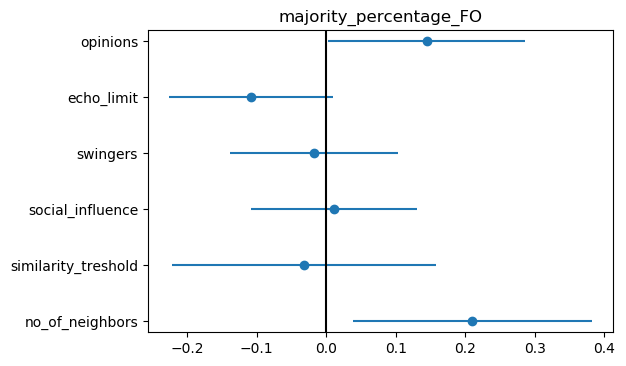

<Figure size 432x288 with 0 Axes>

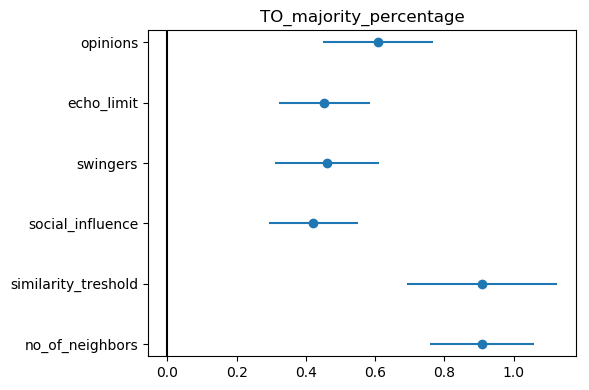

<Figure size 432x288 with 0 Axes>

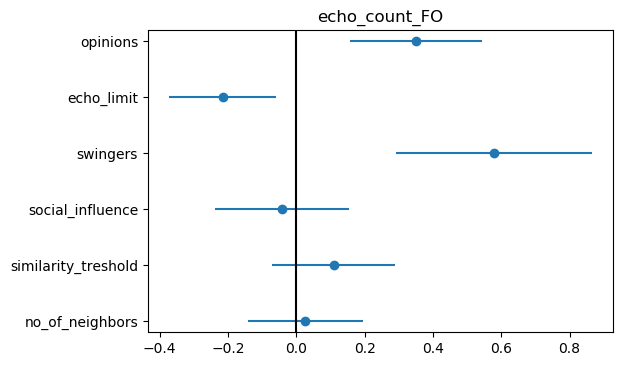

<Figure size 432x288 with 0 Axes>

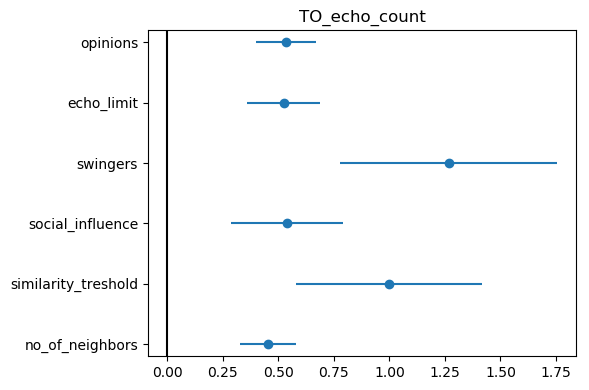

<Figure size 432x288 with 0 Axes>

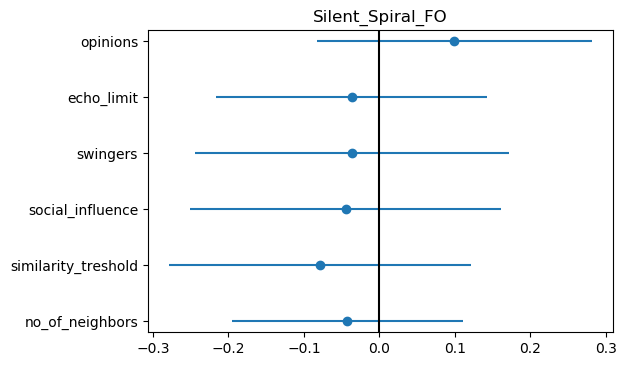

<Figure size 432x288 with 0 Axes>

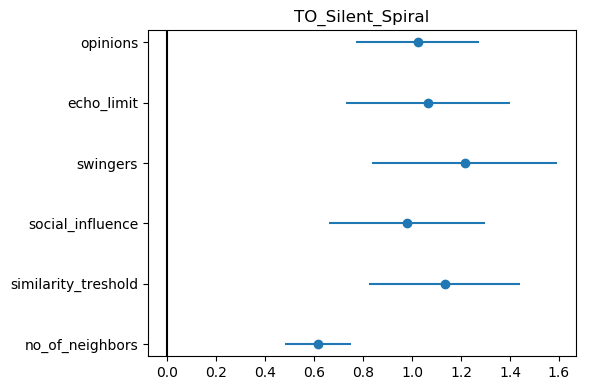

<Figure size 432x288 with 0 Axes>

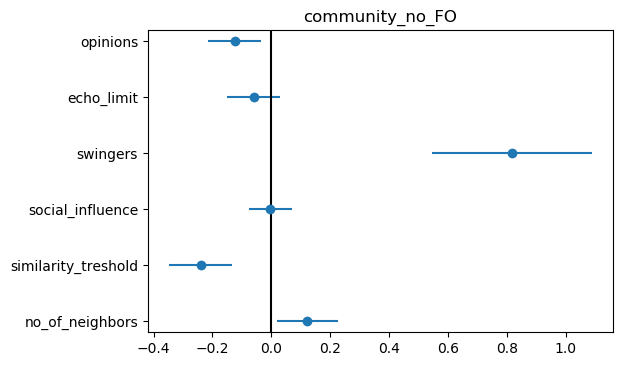

<Figure size 432x288 with 0 Axes>

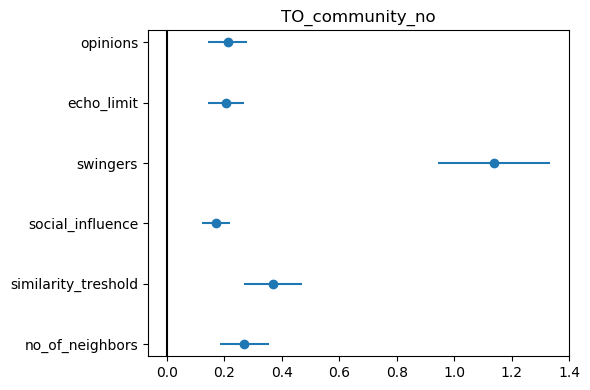

<Figure size 432x288 with 0 Axes>

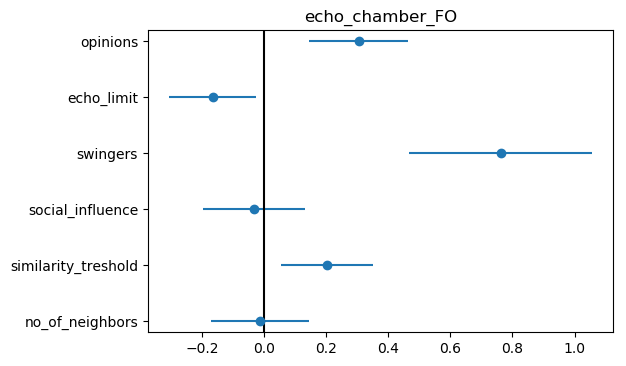

<Figure size 432x288 with 0 Axes>

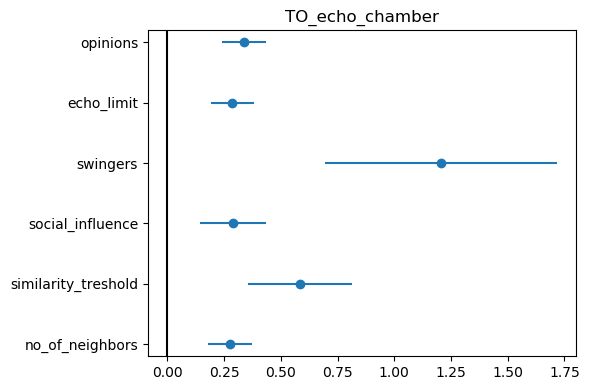

<Figure size 432x288 with 0 Axes>

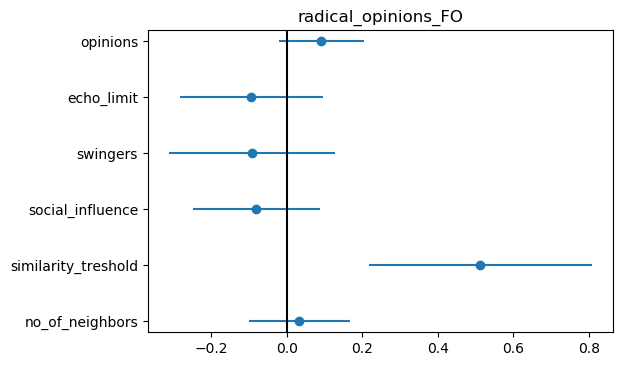

<Figure size 432x288 with 0 Axes>

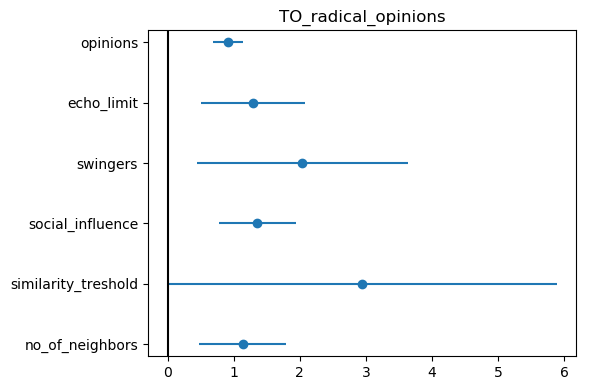

<Figure size 432x288 with 0 Axes>

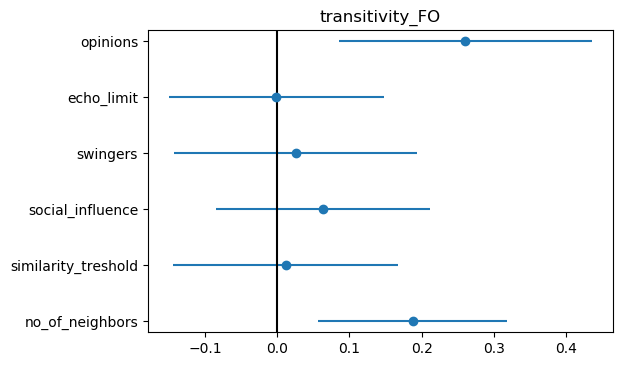

<Figure size 432x288 with 0 Axes>

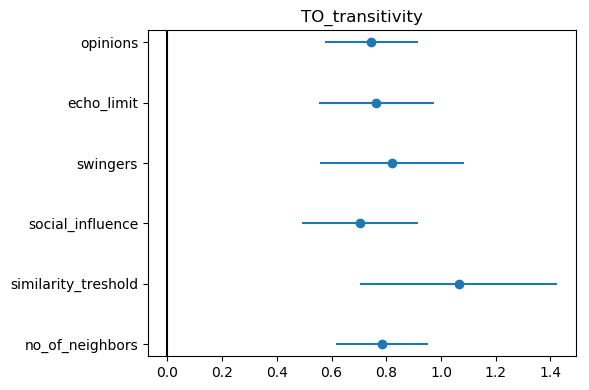

In [96]:
for Si, name in zip(to_plot, names):
    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.title(name+'_FO')
    plt.savefig('./img/SOBOL_FirstOrder_'+name+'.png', bbox_inches='tight')   
    plt.show()


#     # Second order
#     plot_index(Si, problem['names'], '2', 'Second order sensitivity')
#     plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.title('TO_'+name)
    plt.tight_layout()
    plt.savefig('./img/SOBOL_TotalOrder_'+name+'.png',  bbox_inches='tight')    
    plt.show()
    


[2, 3, 4, 5]
['opinions', 'Run', 'community_no', 'echo_chambers', 'majority_opinion', 'radical_opinions', 'silent_spiral', 'N', 'network_type', 'no_of_neighbors', 'beta_component', 'similarity_treshold', 'social_influence', 'swingers', 'malicious_N', 'echo_threshold', 'all_majority']
['community_no', 'echo_chambers', 'majority_opinion', 'radical_opinions', 'silent_spiral']


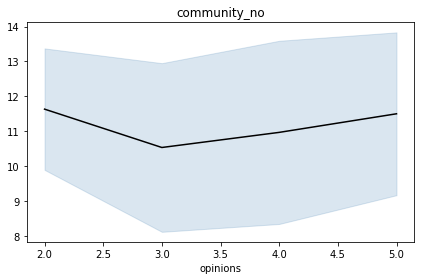

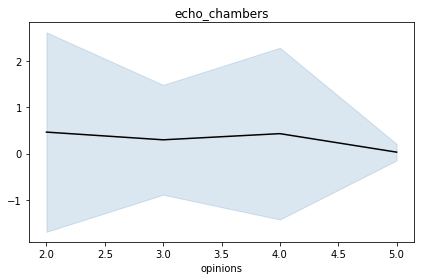

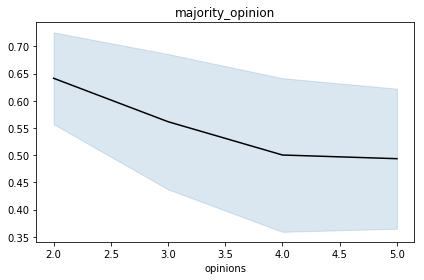

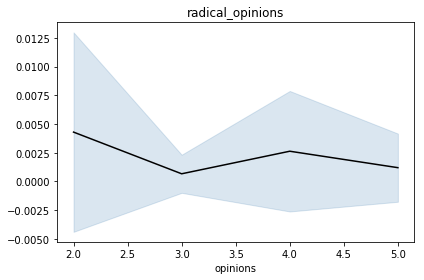

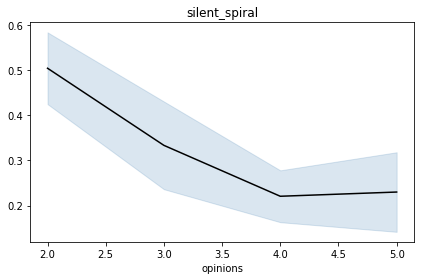

<Figure size 432x288 with 0 Axes>

In [84]:
#### %matplotlib inline
from model import *
from agents import *
from globals import *
# from server import *
from schedule import *
from utility import *
from SALib.sample import saltelli
from mesa.batchrunner import BatchRunner, BatchRunnerMP
import pathos
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import clear_output
import time
import multiprocessing as mp
import analysis


fixed_params = {
    "N": 1000,
    "network_type": 2,
    "no_of_neighbors": 3,
    "beta_component": 0.15,
    "social_influence": 0.06,
    "similarity_treshold": .16,
    "swingers": 3,
    "malicious_N":0,
    "echo_limit": .95,
    "all_majority": False,
    "opinions":2,
}
 
problem = {
    'num_vars': 6,
    'names': ['no_of_neighbors', 'similarity_treshold', 'social_influence','swingers','echo_limit','opinions'],
    'bounds': [[2, 6], [0.01, 0.1], [0.01, .1],[1,5],[.05,.2],[2,5]]
}

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 30
max_steps = 100
distinct_samples = 10


# Set the outputs
model_reporters = {
#                 "preferences": compute_preferences,
#                 "opinions": compute_opinions,
#                 "preference_A": compute_preference_A,
#                 "preference_B": compute_preference_B,
                "radical_opinions": compute_radical_opinions,
                "Silent_Spiral": compute_silent_spiral,
                "majority_percentage": compute_majority_opinions,
                "community_no": community_no,
                "transitivity": compute_transitivity,
                "echo_chamber": compute_echo_chamber,
                "echo_size": echochamber_size,
                "echo_count": echochamber_count,  
}




In [ ]:
data = {}

for i, var in enumerate(problem['names']):
    # Get the bounds for this variable and get <distinct_samples> samples within this space (uniform)
    samples = np.linspace(*problem['bounds'][i], num=distinct_samples)
    
    # Keep in mind that wolf_gain_from_food should be integers. You will have to change
    # your code to acommidate for this or sample in such a way that you only get integers.
    if var == 'no_of_neighbors' or var == 'swingers' or var == "opinions" or var=='N' or var=='network_type' or var=='malicious_N':
        samples = np.linspace(*problem['bounds'][i], num=distinct_samples, dtype=int)
#     print({var: samples})
    fixed_params = {
        "N": 1000,
        "network_type": 2,
        "no_of_neighbors": 3,
        "beta_component": 0.15,
        "social_influence": 0.06,
        "similarity_treshold": .16,
        "swingers": 3,
        "malicious_N":0,
        "echo_limit": .95,
        "all_majority": False,
        "opinions":2,
    }
    

    del fixed_params[var]
#     print(fixed_params)
    batch = BatchRunnerMP(Network, 
                        max_steps=max_steps,
                        iterations=replicates,
                        fixed_parameters=fixed_params,
                        variable_parameters={var: samples},
                        model_reporters=model_reporters,
                        display_progress=True)
    
    batch.run_all()
    
    data[var] = batch.get_model_vars_dataframe()
    

In [2]:
# print(data)

NameError: name 'data' is not defined

In [86]:
# import json
# # print(data)
# for i in data.keys():
# #     data[i]
#     data[i].to_pickle('./Data/OFAT_'+i+'.pkl')
# print(data)

# pd_data = pd.DataFrame.from_dict(data)

# df = json.dumps(data)



# batch.run_all()
# data = batch.get_model_vars_dataframe()
# data.to_pickle('./Data/OFAT_ALL.pkl')
# print(type(data['no_of_neighbors']))
# for name in problem['names']:
#     with open('./Data/OFAT_Final_'+name+'.json', 'w') as fp:
#         json.dump(data[name], fp)

      similarity_treshold  social_influence  swingers  no_of_neighbors  \
0                0.086025          0.097451  3.574219         5.207031   
1                0.092881          0.097451  3.574219         5.207031   
2                0.086025          0.057197  3.574219         5.207031   
3                0.086025          0.097451  4.503906         5.207031   
4                0.086025          0.097451  3.574219         2.777344   
5                0.086025          0.097451  3.574219         5.207031   
6                0.086025          0.097451  3.574219         5.207031   
7                0.092881          0.057197  4.503906         2.777344   
8                0.063525          0.029951  2.574219         2.207031   
9                0.025381          0.029951  2.574219         2.207031   
10               0.063525          0.079697  2.574219         2.207031   
11               0.063525          0.029951  3.503906         2.207031   
12               0.063525          0.0

[1200 rows x 16 columns]


In [90]:
import matplotlib.pyplot as plt

reporters = model_reporters.keys()
params = problem['names']

print(reporters,params)
for param in params:
    subdat = pd.read_pickle('./Data/OFAT_'+param+'.pkl')
#     print(param)
    print(subdat)
    x = subdat[param]
    
#     means = x.groupby([param]).mean()
#     stds = x.groupby([param]).std()
    all_x = x.unique()
#     print(all_x)
    for reporter in reporters:
        if reporter == 'echo_chamber':
            break
        else:
            y = []
            stds = []
            y_min = []
            y_max = []
            for i in all_x:
#                 print(subdat)
                reporter_data = subdat[reporter].loc[subdat[param] == i]
#                 print(reporter_data)
    #         print(reporter_data)

    #         for i in x:
                mean = np.mean(reporter_data)
                std = np.std(reporter_data)
#                 print(mean,std)

                y.append(mean)
                stds.append(std)
                y_min.append(mean - std) 
                y_max.append(mean + std) 
#             print(subdat[param])
            plt.plot(all_x, y, c='k')
            plt.fill_between(all_x, y_min, y_max, color = 'steelblue', alpha=.2)

    #     #     plt.errorbar(x, y,std)
            plt.title('OFAT '+reporter)
            plt.xlabel(param)
            plt.ylabel(reporter)
            plt.tight_layout()
            plt.savefig('./img/OFAT_'+param +'_'+reporter+'.png', bbox_inches='tight')            
            plt.show()


dict_keys(['radical_opinions', 'Silent_Spiral', 'majority_percentage', 'community_no', 'transitivity', 'echo_chamber', 'echo_size', 'echo_count']) ['no_of_neighbors', 'similarity_treshold', 'social_influence', 'swingers', 'echo_limit', 'opinions']
0       5.207031
1       5.207031
2       5.207031
3       5.207031
4       2.777344
5       5.207031
6       5.207031
7       2.777344
8       2.207031
9       2.207031
10      2.207031
11      2.207031
12      3.777344
13      2.207031
14      2.207031
15      3.777344
16      4.207031
17      4.207031
18      4.207031
19      4.207031
20      5.777344
21      4.207031
22      4.207031
23      5.777344
24      3.832031
25      3.832031
26      3.832031
27      3.832031
28      3.652344
29      3.832031
          ...   
1170    2.207031
1171    2.207031
1172    3.777344
1173    2.207031
1174    2.207031
1175    3.777344
1176    4.207031
1177    4.207031
1178    4.207031
1179    4.207031
1180    5.777344
1181    4.207031
1182    4.207031
1183

KeyError: 'no_of_neighbors'

KeyError: 'no_of_neighbors'

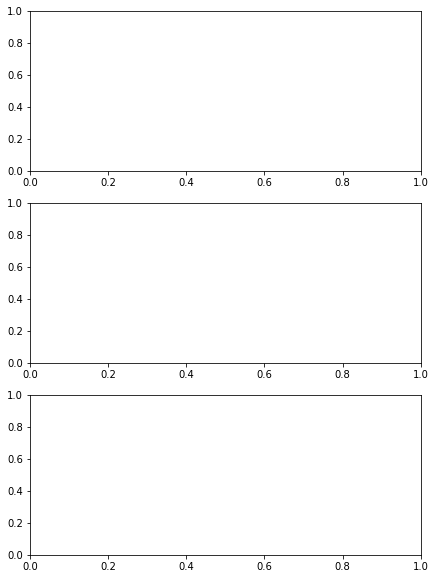

In [60]:
def plot_param_var_conf(ax, df, var, param, i):
    """
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.

    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variables to be taken from the dataframe
        param: which output variable to plot
    """
    x = df.groupby(var).mean().reset_index()[var]
    y = df.groupby(var).mean()[param]

    replicates = df.groupby(var)[param].count()
    err = (1.96 * df.groupby(var)[param].std()) / np.sqrt(replicates)

    ax.plot(x, y, c='k')
    ax.fill_between(x, y - err, y + err)

    ax.set_xlabel(var)
    ax.set_ylabel(param)

def plot_all_vars(df, param):
    """
    Plots the parameters passed vs each of the output variables.

    Args:
        df: dataframe that holds all data
        param: the parameter to be plotted
    """

    f, axs = plt.subplots(3, figsize=(7, 10))
    
    for i, var in enumerate(problem['names']):
        plot_param_var_conf(axs[i], data[var], var, param, i)

for param in variable_params.keys():
    plot_all_vars(data[param], param)
    plt.show()